# Omnivore: A Single Model for Many Visual Modalities

In this notebook, we want to demonstrate how to use the omnivore model loaded its pretrained weight to classify many visual modalities, i.e. image, depth image (rgbd), and video.

In [152]:
import os
import json
from PIL import Image
import numpy as np

import torch
from torchvision.io import read_video, _read_video_from_file
import torchvision.transforms as T

import torchmultimodal.models.omnivore as omnivore
from examples.omnivore.data import presets

from IPython.display import Video
from matplotlib import pyplot as plt

In [36]:
# Get model with pretrained weight
model = omnivore.omnivore_swin_t(pretrained=True)
model = model.eval()

## Inference on Image

In [159]:
# Downloading assets
os.makedirs("assets", exist_ok=True)
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/imagenet_val_ringlet_butterfly_001.JPEG" -P "assets/"
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/imagenet_class.json" -P "assets/"

--2022-07-31 21:22:13--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/imagenet_val_ringlet_butterfly_001.JPEG
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:223b:3200:d:607e:4540:93a1, 2600:9000:223b:2400:d:607e:4540:93a1, 2600:9000:223b:2000:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:223b:3200:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 119761 (117K) [image/jpeg]
Saving to: ‘assets/imagenet_val_ringlet_butterfly_001.JPEG.6’

imagenet_val_ringle 100%[===================>] 116.95K   118KB/s    in 1.0s    

2022-07-31 21:22:17 (118 KB/s) - ‘assets/imagenet_val_ringlet_butterfly_001.JPEG.6’ saved [119761/119761]

--2022-07-31 21:22:17--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/imagenet_class.json
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:223b:e400:d:607e:4540:93a1, 2600:9000:223b:2400:d:607e:4540:9

In [160]:
# Read the class list and image
with open("assets/imagenet_class.json", "r") as fin:
    imagenet_classes = json.load(fin)
pil_img = Image.open("assets/imagenet_val_ringlet_butterfly_001.JPEG")

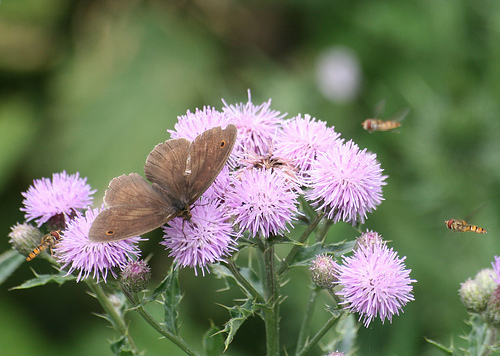

In [161]:
# Show image
pil_img

In [162]:
# Apply transforms
img_val_presets = presets.ImageNetClassificationPresetEval(crop_size=224)
input_img = img_val_presets(pil_img)

# Add batch dimension
input_img = input_img.unsqueeze(0)

In [165]:
# Get top5 labels
preds = model(input_img, "image")
top5_values, top5_indices = preds[0].topk(5)
top5_labels = [imagenet_classes[index] for index in top5_indices.tolist()]
top5_labels

# The correct label is a ringlet butterfly, see: https://en.wikipedia.org/wiki/Ringlet

['ringlet', 'cardoon', 'admiral', 'sulphur butterfly', 'bee']

## Inference on Video

In [166]:
# Downloading assets
os.makedirs("assets", exist_ok=True)
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/kinetics400_val_snowboarding_001.mp4" -P "assets/"
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/kinetics400_class.json" -P "assets/"


--2022-07-31 21:25:08--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/kinetics400_val_snowboarding_001.mp4
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:223b:1400:d:607e:4540:93a1, 2600:9000:223b:4800:d:607e:4540:93a1, 2600:9000:223b:800:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:223b:1400:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1546256 (1.5M) [video/mp4]
Saving to: ‘assets/kinetics400_val_snowboarding_001.mp4.3’

kinetics400_val_sno 100%[===================>]   1.47M   300KB/s    in 8.0s    

2022-07-31 21:25:19 (188 KB/s) - ‘assets/kinetics400_val_snowboarding_001.mp4.3’ saved [1546256/1546256]

--2022-07-31 21:25:19--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/kinetics400_class.json
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:223b:6e00:d:607e:4540:93a1, 2600:9000:223b:4800:d:607e:4540:93a1, 

In [168]:
# Read class list and video
with open("assets/kinetics400_class.json", "r") as fin:
    kinetics400_classes = json.load(fin)
video, audio, info = read_video("assets/kinetics400_val_snowboarding_001.mp4", output_format="TCHW")

# Since we sampled at 16 fps for training, and the input video is 30 fps
# we resample every 2 frames so it become 15 fps and closer to training fps
video = video[::2]

# Use first 50 frames
video = video[:50]


/Users/yosuamichael/manual_build_lib/pytorch/vision/torchvision/io/video.py:162: UserWarning: The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.
  warnings.warn("The pts_unit 'pts' gives wrong results. Please use pts_unit 'sec'.")


In [169]:
# Show video
Video("assets/kinetics400_val_snowboarding_001.mp4", width=512)

In [170]:
# Apply transforms
video_val_presets = presets.VideoClassificationPresetEval(crop_size=224, resize_size=224)
input_video = video_val_presets(video)
# Add batch dimension
input_video = input_video.unsqueeze(0)

In [171]:
# Get top5 labels
preds = model(input_video, "video")
top5_values, top5_indices = preds[0].topk(5)
top5_labels = [kinetics400_classes[index] for index in top5_indices.tolist()]
top5_labels

# The correct label is snowboarding

['snowboarding',
 'skiing_(not_slalom_or_crosscountry)',
 'ski_jumping',
 'ice_climbing',
 'faceplanting']

## Inference on depth image

In [172]:
# Downloading assets
os.makedirs("assets", exist_ok=True)
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_val_kitchen_depth_001.png" -P "assets/"
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_val_kitchen_image_001.jpg" -P "assets/"
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_val_kitchen_intrinsics_001.txt" -P "assets/"
!wget "https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_class.json" -P "assets/"


--2022-07-31 21:27:09--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_val_kitchen_depth_001.png
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:21f0:4e00:d:607e:4540:93a1, 2600:9000:21f0:3e00:d:607e:4540:93a1, 2600:9000:21f0:5c00:d:607e:4540:93a1, ...
Connecting to download.pytorch.org (download.pytorch.org)|2600:9000:21f0:4e00:d:607e:4540:93a1|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 59761 (58K) [image/png]
Saving to: ‘assets/sunrgbd_val_kitchen_depth_001.png.2’

sunrgbd_val_kitchen 100%[===================>]  58.36K   101KB/s    in 0.6s    

2022-07-31 21:27:13 (101 KB/s) - ‘assets/sunrgbd_val_kitchen_depth_001.png.2’ saved [59761/59761]

--2022-07-31 21:27:13--  https://download.pytorch.org/torchmultimodal/examples/omnivore/assets/sunrgbd_val_kitchen_image_001.jpg
Resolving download.pytorch.org (download.pytorch.org)... 2600:9000:21f0:3a00:d:607e:4540:93a1, 2600:9000:21f0:3e00:d:607e:4540:93a1, 2600

In [173]:
# Read class list
with open("assets/sunrgbd_class.json", "r") as fin:
    sunrgbd_classes = json.load(fin)

In [174]:
# Read depth image
with open("assets/sunrgbd_val_kitchen_intrinsics_001.txt", "r") as fin:
    lines = fin.readlines()
    focal_length = float(lines[0].strip().split()[0])
    
# Baseline of kv2 sensor of sunrgbd (where this depth image come from)
baseline = 0.075

img_depth = Image.open("assets/sunrgbd_val_kitchen_depth_001.png")
_to_tensor = T.ToTensor()
tensor_depth = _to_tensor(img_depth)
tensor_disparity = baseline * focal_length / (tensor_depth / 1000.0)

img_rgb = Image.open("assets/sunrgbd_val_kitchen_image_001.jpg")
tensor_rgb = _to_tensor(img_rgb)

tensor_rgbd = torch.cat((tensor_rgb, tensor_disparity), dim=0)

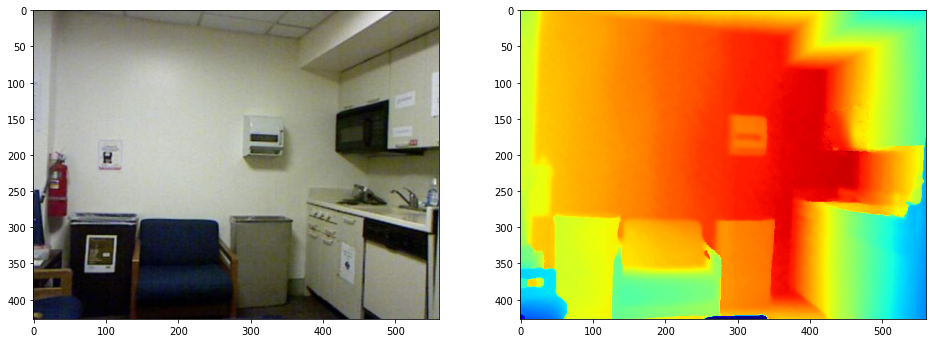

In [180]:
# Show depth image
fig = plt.figure(figsize=(16, 16))

fig.add_subplot(1, 2, 1)
plt.imshow(np.asarray(img_rgb))

fig.add_subplot(1, 2, 2)
plt.imshow(np.asarray(img_depth), cmap="jet")

In [181]:
# Apply transforms
depth_val_presets = presets.DepthClassificationPresetEval(crop_size=224, resize_size=224)
input_depth = depth_val_presets(tensor_rgbd)
# Add batch dimension
input_depth = input_depth.unsqueeze(0)

In [183]:
# Get top5 predictions
preds = model(input_depth, "rgbd")
top5_values, top5_indices = preds[0].topk(5)
top5_labels = [sunrgbd_classes[index] for index in top5_indices.tolist()]
top5_labels

# The correct lable is kitchen

['living_room', 'kitchen', 'office', 'rest_space', 'computer_room']